In [1]:
import numpy as np
import matplotlib.pylab as plot
from astropy.io import ascii,fits
from scipy import interpolate
import grb_catalogs
from BurstCube.LocSim.Detector import *
from BurstCube.LocSim.Spacecraft import *
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.optimize import curve_fit
from astropy.table import Table
import pandas as pd
import healpy as hp

In [2]:
## code to use when reading in GBM effective area in order to get data into the desired format
def getGBMdata(gbmfile=None):
    """Reads the GBM NaI effective area file and returns a numpy array
    with two columns ``energy`` and ``aeff``.
    Parameters
    ----------
    gbmfile : string
       Name of file that contains the GBM data.
    Returns
    ----------
    gbmdata : array 
    numpy array with two columns ``energy`` and ``aeff``
    """
    
    return np.genfromtxt(gbmfile,skip_header=2,names=('energy', 'aeff'))


In [3]:
## bit of useful code for interpolating in log space
def loginterpol(x,y,x1):

    f=interpolate.interp1d(np.log10(x),np.log10(y),bounds_error=False,fill_value="extrapolate",kind='linear')
    y1=10**f(np.log10(x1))

    return y1

def loginterpol2d(x,y,z,x1,y1):

    wz=np.where(z==0)[0]
    zz=z
    zz[wz]=1.
    f=interpolate.interp2d(x,y,np.log10(zz),bounds_error=False,fill_value="extrapolate",kind='linear')
    z1=10**f(x1,y1)

In [4]:
#read in GBM Trigger Catalog
trigfit=fits.open('/home/alyson/NASA/Simulation/BurstCube/Users/ajoens/gbmtrigcat.fits')
trig=trigfit[1].data

#read in GBM Burst Catalog
gbmfit=fits.open('/home/alyson/NASA/Simulation/BurstCube/Users/ajoens/gbmgrbcat_copy.fits')
gbm=gbmfit[1].data


In [5]:
## generate random positions on the sky with equal area probability
def random_sky(n=1):

    u=np.random.rand(n)
    v=np.random.rand(n)

    phi=2*np.pi*u
    theta=np.arccos(2*v-1.)

    dec=-np.degrees(theta-np.pi/2.)
    ra=np.degrees(np.pi*2-phi)

    return ra,dec

In [6]:
#function to match GRBs in the Trigger catalog to those in the grb catalog so that we can create an array of the grbs in both
#We will use the trigger timescale found in the trigger catalog 
def match_catalogs_name(name1,name2):

    ind_dict = dict((q,e) for e,q in enumerate(name1))
    inter = set(ind_dict).intersection(name2)
    m1 = [ind_dict[element] for element in inter]
    print(np.shape(m1))
    
    ind_dict = dict((q,e) for e,q in enumerate(name2))
    inter = set(ind_dict).intersection(name1)
    m2 = [ind_dict[element] for element in inter]
    print(np.shape(m2))
    
    return m1,m2


In [7]:
#ordering the trig and gbm catalog so that they are in the same order
so=np.argsort(np.array(trig['NAME']))
trig=trig[so]
so=np.argsort(np.array(gbm['NAME']))
gbm=gbm[so]

#creating array of grbs that are found in both catalogs
m1, m2 = match_catalogs_name(trig['NAME'],gbm['NAME'])

#defining our two samples of bursts that are found in both catalogs so that we can utilize them further down
trigbursts = trig[m1]
gbmbursts = gbm[m2]
print(gbmbursts['NAME'])

(2352,)
(2352,)
['GRB140508128' 'GRB130803419' 'GRB110722710' ... 'GRB160301215'
 'GRB160629930' 'GRB120101354']


In [8]:
## read in the GBM Aeff
aeff_gbm = getGBMdata('/home/alyson/NASA/Simulation/BurstCube/Users/ajoens/gbm_effective_area.dat')

In [9]:
## read in BurstCube Aeff for various BC configurations
file='/home/alyson/NASA/Simulation/BurstCube/Users/jracusin/BC_eff_area_curves.ecsv'
bcaeffs=ascii.read(file,format='ecsv')

In [10]:
## separate GBM short & long GRBs
w=np.where(gbmbursts['FLUX_1024']>0)
gbmbursts=gbmbursts[w]
s=np.where((gbmbursts['T90'] <= 2.)&((gbmbursts['PFLX_SPECTRUM_STOP']-gbmbursts['PFLX_SPECTRUM_START'])>0))[0]
l=np.where(gbmbursts['T90'] > 2.)[0]
m=np.where(gbmbursts['PFLX_BEST_FITTING_MODEL'][s] == ' ')

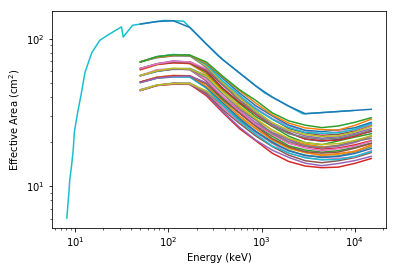

In [11]:
## grab short GRBs with peak spectral info & plot all of the Aeff curves
bceng=bcaeffs['keV']
bcengdiff=bceng[1:]-bceng[0:-1]
w=np.where(bcengdiff<0)[0]
nsims=len(w)
w=np.append(-1,w)#,len(eng))
for i in range(nsims):
    plot.plot(bcaeffs['keV'][w[i]+1:w[i+1]+1],bcaeffs['aeff'][w[i]+1:w[i+1]+1])
plot.xscale('log')
plot.yscale('log')
plot.xlabel('Energy (keV)')
plot.ylabel(r'Effective Area (cm$^2$)')
plot.plot(aeff_gbm['energy'],aeff_gbm['aeff'])
i=0
gbmae=loginterpol(aeff_gbm['energy'],aeff_gbm['aeff'],bceng[w[i]+1:w[i+1]+1])
plot.plot(bceng[w[i]+1:w[i+1]+1],gbmae)

plot.show()

In [12]:
w=np.where((bcaeffs['diameter']==90) & (bcaeffs['height']==19) )
print(bcaeffs[w])
BCaeffs=bcaeffs[w]

diameter height  az  ze   keV     aeff  aeff_eres aeff_eres_modfrac
-------- ------ --- --- ------- ------- --------- -----------------
    90.0   19.0 0.0 0.0    50.0 56.0057     47.28           54.9864
    90.0   19.0 0.0 0.0 75.1462 60.1213   54.4458           58.8948
    90.0   19.0 0.0 0.0 112.939 61.7605    57.709           60.0127
    90.0   19.0 0.0 0.0 169.739 61.7576    57.484           59.5096
    90.0   19.0 0.0 0.0 255.105 54.1984   46.5997           47.9276
    90.0   19.0 0.0 0.0 383.404 42.0248   28.8543           29.4006
    90.0   19.0 0.0 0.0 576.227 33.3321   16.7727            17.036
    90.0   19.0 0.0 0.0 866.025 27.8825   10.3667           20.7725
    90.0   19.0 0.0 0.0 1301.57 22.6889   6.15776           12.3291
    90.0   19.0 0.0 0.0 1956.16 19.9883   4.07161           8.16321
    90.0   19.0 0.0 0.0 2939.97 18.7626   2.57235           5.15783
    90.0   19.0 0.0 0.0 4418.55 18.1448   1.48243           2.97575
    90.0   19.0 0.0 0.0 6640.74 18.8384  0.83077

In [13]:
## grab energies from those curves and create an array of the energies
#E=np.array(bceng[w[i]+1:w[i+1]+1])
#print(E)

In [14]:
#Integrating the best fit spectrum for each GRB in the energy range of 50-300 KeV to get max. observed photon flux. 
#Doing the same but also folding in the effective area in order to get count rate.
#This will give us the photon flux in units of ph/cm^2/s. 
mo=gbmbursts['PFLX_BEST_FITTING_MODEL'][s]
bcpf=np.zeros(len(s)) 
pf=np.zeros(len(s))
gbmcr=np.zeros(len(s))
bccr=np.zeros(len(s))
outE=np.logspace(np.log10(50),np.log10(300),100) # returns numbers spaced evenly on a log scale
for i in range(len(s)):
    for j in range(nsims):
#        E=np.array(bceng[w[j]+1:w[j+1]+1])
#        AeffBC=loginterpol(E,bcaeffs['aeff'][w[j]+1:w[j+1]+1],outE)
        E=np.array(BCaeffs['keV'])
        AeffBC=loginterpol(E,BCaeffs['aeff_eres_modfrac'],outE)
        AeffGBM=loginterpol(aeff_gbm['energy'],aeff_gbm['aeff'],outE) #eng[w[j]+1:w[j+1]+1])       
        Aratio=(AeffBC/AeffGBM)
    
        # this should give us an array of the maximum observed photon flux for GBM
        if mo[i]=='PFLX_PLAW':
            gbmcr[i]=np.trapz(gbmbursts['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs.pl(outE,gbmbursts['PFLX_PLAW_INDEX'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbmbursts['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs.pl(outE,gbmbursts['PFLX_PLAW_INDEX'][s[i]]),outE)
            bccr[i]=np.trapz(gbmbursts['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs.pl(outE,gbmbursts['PFLX_PLAW_INDEX'][s[i]])*AeffGBM*Aratio,outE)
            bcpf[i]=np.trapz(gbmbursts['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs.pl(outE,gbmbursts['PFLX_PLAW_INDEX'][s[i]]),outE)
    
        if mo[i]=='PFLX_COMP':
            gbmcr[i]=np.trapz(gbmbursts['PFLX_COMP_AMPL'][s[i]]*grb_catalogs.comp(outE,gbmbursts['PFLX_COMP_INDEX'][s[i]],gbmbursts['PFLX_COMP_EPEAK'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbmbursts['PFLX_COMP_AMPL'][s[i]]*grb_catalogs.comp(outE,gbmbursts['PFLX_COMP_INDEX'][s[i]],gbmbursts['PFLX_COMP_EPEAK'][s[i]]),outE)
            bccr[i]=np.trapz(gbmbursts['PFLX_COMP_AMPL'][s[i]]*grb_catalogs.comp(outE,gbmbursts['PFLX_COMP_INDEX'][s[i]],gbmbursts['PFLX_COMP_EPEAK'][s[i]])*AeffGBM*Aratio,outE)
            bcpf[i]=np.trapz(gbmbursts['PFLX_COMP_AMPL'][s[i]]*grb_catalogs.comp(outE,gbmbursts['PFLX_COMP_INDEX'][s[i]],gbmbursts['PFLX_COMP_EPEAK'][s[i]]),outE)
    
        if mo[i]=='PFLX_BAND':
            gbmcr[i]=np.trapz(gbmbursts['PFLX_BAND_AMPL'][s[i]]*grb_catalogs.band(outE,gbmbursts['PFLX_BAND_ALPHA'][s[i]],gbmbursts['PFLX_BAND_EPEAK'][s[i]],gbmbursts['PFLX_BAND_BETA'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbmbursts['PFLX_BAND_AMPL'][s[i]]*grb_catalogs.band(outE,gbmbursts['PFLX_BAND_ALPHA'][s[i]],gbmbursts['PFLX_BAND_EPEAK'][s[i]],gbmbursts['PFLX_BAND_BETA'][s[i]]),outE)
            bccr[i]=np.trapz(gbmbursts['PFLX_BAND_AMPL'][s[i]]*grb_catalogs.band(outE,gbmbursts['PFLX_BAND_ALPHA'][s[i]],gbmbursts['PFLX_BAND_EPEAK'][s[i]],gbmbursts['PFLX_BAND_BETA'][s[i]])*AeffGBM*Aratio,outE)
            bcpf[i]=np.trapz(gbmbursts['PFLX_BAND_AMPL'][s[i]]*grb_catalogs.band(outE,gbmbursts['PFLX_BAND_ALPHA'][s[i]],gbmbursts['PFLX_BAND_EPEAK'][s[i]],gbmbursts['PFLX_BAND_BETA'][s[i]]),outE)

        if mo[i]=='PFLX_SBPL':
            gbmcr[i]=np.trapz(gbmbursts['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs.sbpl(outE,gbmbursts['PFLX_SBPL_INDX1'][s[i]],gbmbursts['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]])*AeffGBM,outE)
            pf[i]=np.trapz(gbmbursts['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs.sbpl(outE,gbmbursts['PFLX_SBPL_INDX1'][s[i]],gbmbursts['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]]),outE)
            bccr[i]=np.trapz(gbmbursts['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs.sbpl(outE,gbmbursts['PFLX_SBPL_INDX1'][s[i]],gbmbursts['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]])*AeffGBM*Aratio,outE)
            bcpf[i]=np.trapz(gbmbursts['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs.sbpl(outE,gbmbursts['PFLX_SBPL_INDX1'][s[i]],gbmbursts['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]]),outE)



In [15]:
#plot Batse[64] against pf to see if they are the same
flux=gbmbursts['FLUX_BATSE_64'][s]
print(pf.shape[0])

339


In [16]:
#define probability
#p = np.array((np.arange(pf.shape[0])+1)**(-1.0))
p = np.array((np.arange(pf.shape[0])+1)**(-0.7))
p=p/sum(p)
#randomly sample from the array of photon fluxes found above using our probability function found above so we draw more low flux bursts
#creating our "intrinsic" sample
r=np.random.choice(pf.shape[0],3000, replace=True, p=p)

simgbmpfsample = np.array(pf[r])
simgbmcr = np.array(gbmcr[r])
simbcpfsample = np.array(bcpf[r])
simbccr = np.array(bccr[r])


0.0010346972779119955 0.061087604544997454


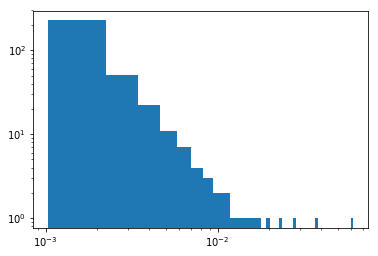

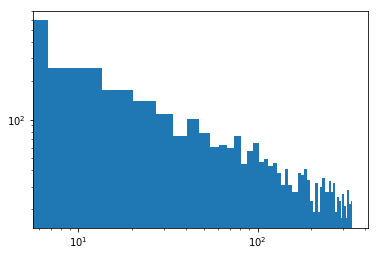

In [17]:
#examining our probability distribution to be sure it is performing the eay we intend it to
print(min(p),max(p))
plot.hist(p,bins=50)
plot.xscale('log')
plot.yscale('log')

plot.figure()
plot.hist(r,bins=50)
plot.xscale('log')
plot.yscale('log')

In [18]:
## setup GBM
gbm_pointings = {'01': ('45:54:0','20:36:0'),
            '02': ('45:6:0','45:18:0'),
            '03': ('58:24:0','90:12:0'),
            '04': ('314:54:0','45:12:0'),
            '05': ('303:12:0','90:18:0'),
            '06': ('3:24:0','89:48:0'),
            '07': ('224:54:0','20:24:0'),
            '08': ('224:36:0','46:12:0'),
            '09': ('236:36:0','90:0:0'),
            '10': ('135:12:0','45:36:0'),
            '11': ('123:42:0','90:24:0'),
            '12': ('183:42:0','90:18:0')}

npointings=len(gbm_pointings)
fermi = Spacecraft(gbm_pointings,lat='00:00:00',lon='260:00:00')
NSIDE = 32
exposure_positions_hp = np.arange(hp.nside2npix(NSIDE))
exposure_positions_pix = hp.pix2ang(NSIDE, exposure_positions_hp, lonlat=True)
exposure_positions = np.vstack(exposure_positions_pix)
gbm_exposures = np.array([[detector.exposure(position[0],position[1], alt=-10.,index=0.77) for position in exposure_positions.T] 
                      for detector in fermi.detectors])

plot.figure(figsize=(20,npointings))
for i in range(npointings):
    hp.mollview(gbm_exposures[i]/max(gbm_exposures[i]), max=1,title='Detector '+gbm_pointings.keys()[i],\
                sub = [int(npointings/3.),3,int(str(i+1))])
exps=gbm_exposures.sum(axis=0)
fs=(exps-min(exps))/max(exps)
hp.mollview(fs,title='Sum of All Detectors')

TypeError: exposure() got an unexpected keyword argument 'alt'

In [ ]:
## setup BurstCube
pointings = {'01': ('45:0:0','45:0:0'),
           '02': ('135:0:0','45:0:0'),
           '03': ('225:0:0','45:0:0'),
           '04': ('315:0:0','45:0:0')}

npointings=len(pointings)
burstcube = Spacecraft(pointings,lat='00:00:00',lon='260:00:00')
NSIDE = 32
exposure_positions_hp = np.arange(hp.nside2npix(NSIDE))
exposure_positions_pix = hp.pix2ang(NSIDE, exposure_positions_hp, lonlat=True)
exposure_positions = np.vstack(exposure_positions_pix)
exposures = np.array([[ detector.exposure(position[0],position[1], alt=-10.,index=0.77) for position in exposure_positions.T] 
                      for detector in burstcube.detectors])

plot.figure(figsize=(20,npointings))
for i in range(npointings):
    hp.mollview(exposures[i]/max(exposures[i]), max=1,title='Detector '+pointings.keys()[i],\
                sub = [np.round(npointings/3.+0.5),3,int(str(i+1))])
exps=exposures.sum(axis=0)
fs=(exps-min(exps))/max(exps)
hp.mollview(fs,title='Sum of All Detectors')

In [ ]:
#using SkyCoord to convert coordinates to degrees and solve for distances.
def separation(ra1,dec1,ra2,dec2):

    c=SkyCoord(ra=ra1*u.deg,dec=dec1*u.deg)
    d=SkyCoord(ra=ra2*u.deg,dec=dec2*u.deg)
    dist=c.separation(d)
    dist=dist.value

    return dist

In [ ]:
# now that GBM and BurstCube's pointings are set up we will throw GRBs at it and determine the exposure for each GRB. 
#generate GRBs and throw them at GBM

def throw_grbs(fermi,minflux,maxflux):
    
    nsims=int(np.round(len(simgbmpfsample))) 
    ra,dec=random_sky(nsims)
    ra=np.array(ra)-180
    dec=np.array(dec)
     

    #GBM and BurstCube exposures for each random GRB.
    randgbmexposures = np.array([[detector.exposure(ra[i],dec[i]) for i in range(nsims)] for detector in fermi.detectors])
    randbcexposures = np.array([[detector.exposure(ra[i],dec[i]) for i in range(nsims)] for detector in burstcube.detectors])
    
    #Order randgbmexposures into descending order
    for column in randgbmexposures.T:
        newrandgbm = -np.sort(-randgbmexposures.T) 
    gbmexposures = np.transpose(newrandgbm)
    
    for col in randbcexposures.T:
        newrandbc = -np.sort(-randbcexposures.T) 
    bcexposures = np.transpose(newrandbc)

    
    #Select the second highest exposure value. 
    #We will use this to ensure the second highest exposure detector has a sig >4.5
    secondhighestgbm = gbmexposures[1,:]
    secondhighestbc = bcexposures[1,:]
        
    return gbmexposures, bcexposures, secondhighestgbm, secondhighestbc, randgbmexposures, randbcexposures

In [ ]:
#define the peak flux interval using the trigger catalog
msinterval = trigbursts['Trigger_Timescale'][s] 
interval = msinterval/1000


In [ ]:
#flux=simpf this is in ph/sec
flux=simgbmpfsample
minflux=min(flux)
maxflux=max(flux)
gbmexposures, bcexposures, secondhighestgbm, secondhighestbc, randgbmexposures, randbcexposures = throw_grbs(fermi,minflux,maxflux)



In [ ]:
#Solve for the number of detected counts which will equal our source photons
sourcegbm = simgbmcr*secondhighestgbm*interval[r]
sourcebc = simbccr*secondhighestbc*interval[r]

In [ ]:
#Assuming a background count rate. units: cts/s
bckgrd=300

#scale the background count rate for the second highest detector
scaledgbmbckgrd = bckgrd*secondhighestgbm*interval[r]
scaledbcbckgrd = bckgrd*secondhighestbc*interval[r]*0.5


In [ ]:
#creating an array of zeros that I can manipulate to create an array of detected GRBs
detectgbm = np.zeros(len(simgbmpfsample))
detectbc = np.zeros(len(simbcpfsample))

#calculate the significance of the second highest exposure detector. If the significance is greater than 4.5 sigma than the burst is detectable.
for u in range(len(simgbmpfsample)):
    sig = sourcegbm[u] / (np.sqrt(sourcegbm[u] + scaledgbmbckgrd[u]))
    if sig > 4.5:
        detectgbm[u] = 1.0
    else:
        detectgbm[u] = 0.0

for j in range(len(simbcpfsample)):
    sig = sourcebc[j] / (np.sqrt(sourcebc[j] + scaledbcbckgrd[j]))
    if sig > 4.5:
        detectbc[j] = 1.0
    else:
        detectbc[j] = 0.0


In [ ]:
#Creating plot of peak flux versus counts for real and simulated GBM
w=np.where(pf>0)[0]
wg = np.where(simgbmcr*detectgbm>0)[0]
wbc = np.where(simbccr*detectbc>0)[0]


fig=plot.figure(figsize=(20,5))
plot.subplot(1,2,1)
plot.hist(gbmcr[w],label='real GBM',bins=np.logspace(1,6,40),color='orange')
plot.hist(simgbmcr[wg],label='Simulated GBM',bins=np.logspace(1,6,40),alpha=0.7,color='blue')
plot.hist(simbccr[wbc],label='Simulated BurstCube',bins=np.logspace(1,6,40),alpha=0.7,color='green')
plot.xlabel('Count Rate (50-300 keV; cts/s)')
plot.xscale('log')
plot.legend()
plot.subplot(1,2,2)
#plot.hist(flux,label='All',bins=np.logspace(-1,2,40),color='green')
#pf has been gathered from the GBM catalog
plot.hist(pf[w],label='real GBM',bins=np.logspace(-1,4,40),color='orange')
# this is the simulated GBM
plot.hist(simgbmpfsample[wg],label='Simulated GBM',bins=np.logspace(-1,4,40),alpha=0.7,color='blue')
plot.hist(simbcpfsample[wbc],label='Simulated BurstCube',bins=np.logspace(-1,4,40),alpha=0.7,color='green')
plot.xlabel('Peak Flux (50-300 keV; ph/cm2/s)')
#plot.hist(flux[w],label='BC',bins=np.logspace(-1,2,40),alpha=0.7,color='red')
plot.xscale('log')
plot.legend()

plot.show()
        

In [ ]:
#solve for the detection fraction of BurstCube and Simulated GBM
detgbm = np.where(detectgbm == 1)[0]
ratiogbm = len(detgbm)*1. / len(detectgbm)
print(ratiogbm)

detbc = np.where(detectbc == 1)[0]
ratiobc = len(detbc)*1. / len(detectbc)
print(ratiobc)

#number of bursts BurstCube will see a year
bcbursts = ratiobc/ratiogbm *40.
print(bcbursts)